<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Iris/blob/main/0_baseline_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This file does NOT contain high quality code! This file is dedicated to the skill of writing pipelines quickly

# Setup code

In [52]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [53]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/9.Iris/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

In [54]:
manager.models_root_path

'/content/gdrive/MyDrive/ML/Competitions/9.Iris/Models'

# Download the data

In [55]:
df_train = pd.read_csv(manager.train_path, index_col=None)
df_test = pd.read_csv(manager.test_path, index_col=None)

In [56]:
df_train.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.045070,2.508203,3.018024,1.164924,Iris-versicolor
1,6.325517,2.115481,4.542052,1.413651,Iris-versicolor
2,5.257497,3.814303,1.470660,0.395348,Iris-setosa
3,6.675168,3.201700,5.785461,2.362764,Iris-virginica
4,5.595237,2.678166,4.077750,1.369266,Iris-versicolor


In [57]:
df_train.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [58]:
df_train.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

# Quick look at the data

## Nan check

In [59]:
_ = nan_statistics(df_train)
_ = nan_statistics(df_test)

Col -- Nan percentage
petal_length 7.6190476190476195
sepal_width 3.8095238095238098
Col -- Nan percentage


In [60]:
df_train.isna().mean()

sepal_length    0.000000
sepal_width     0.038095
petal_length    0.076190
petal_width     0.000000
species         0.000000
dtype: float64

# Data exploration

## How to better impute nans?

In [61]:
has_nans_in_rows = df_train.apply(
    lambda item: item.isna().sum() > 0,
    axis=1
)
df_train.loc[has_nans_in_rows, :].head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
7,5.205868,NaN,1.675654,0.112269,Iris-setosa
21,6.365979,NaN,4.964905,1.817211,Iris-virginica
30,5.673096,4.409565,NaN,0.370518,Iris-setosa
32,5.847160,2.743619,NaN,0.748681,Iris-versicolor
37,6.271780,2.521065,NaN,1.896626,Iris-virginica
39,5.040516,3.466344,NaN,0.314548,Iris-setosa
41,4.496342,3.098270,NaN,0.242853,Iris-setosa
50,5.817283,2.633800,NaN,1.141347,Iris-versicolor
54,6.265590,NaN,4.701306,1.290187,Iris-versicolor
64,6.340344,NaN,4.302989,1.331797,Iris-versicolor


In [62]:
from sklearn_utils import nan_report
_ = nan_report(df_train, 0.0)

2 / 5 cols (40.0 %) have nan % > 0.0

sepal_width     0.038095
petal_length    0.076190
dtype: float64


<Axes: >

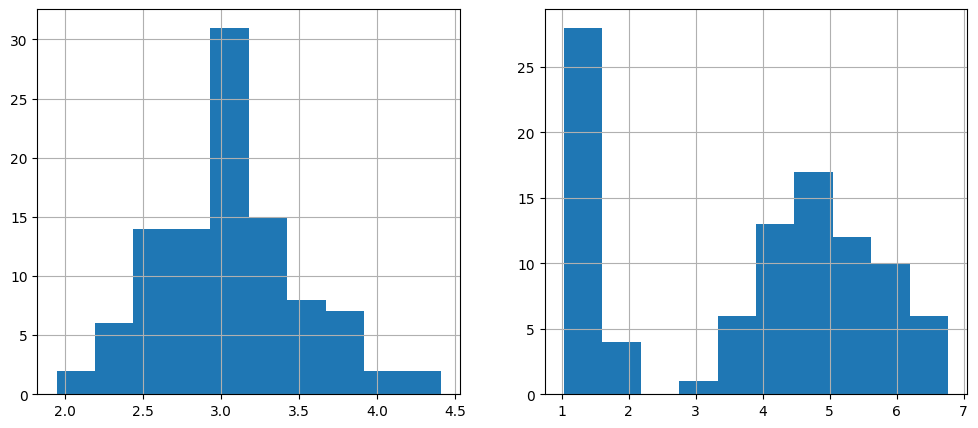

In [63]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
df_train['sepal_width'].hist(ax=ax[0])
df_train['petal_length'].hist(ax=ax[1])

- We will try with KNN imputing of NAN values

# Split the data

In [64]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8

df_trainval, df_test = train_test_split(
    df_train,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train['species']
)

df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['species']
)

df_train.size, df_val.size, df_test.size

(335, 85, 105)

In [67]:
def X_Y(df):
    X = df.loc[:, df.columns != 'species']
    Y = df[['species']]
    return X, Y

X_train, Y_train = X_Y(df_train)
X_val, Y_val = X_Y(df_val)
X_test, Y_test = X_Y(df_test)

Text(0.5, 0.98, 'Class distribution')

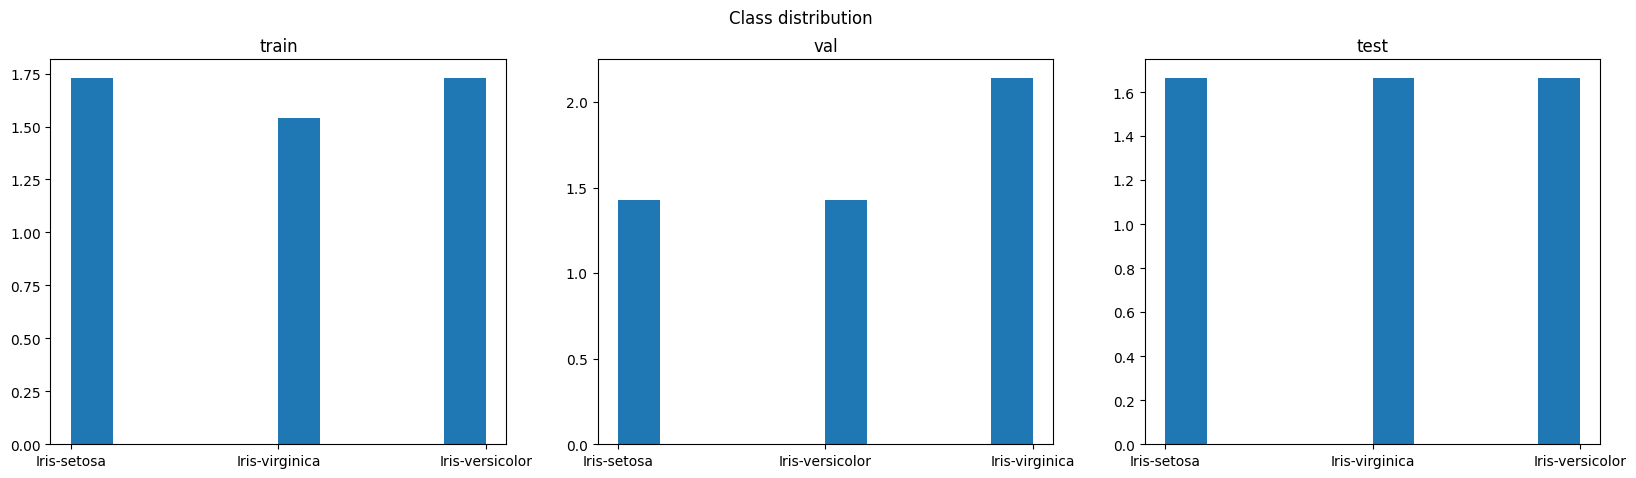

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
_ = ax[0].hist(Y_train, label='train', density=True)
ax[0].set_title('train')

_ = ax[1].hist(Y_val, label='val', density=True)
ax[1].set_title('val')

_ = ax[2].hist(Y_test, label='test', density=True)
ax[2].set_title('test')

fig.suptitle('Class distribution')

# Preprocessing pipeline

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

num_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
num_pipeline = make_pipeline(
    KNNImputer(
        n_neighbors=5,
        weights='distance'
    ),
    StandardScaler()
)

In [70]:
has_nans_in_rows = df_train.apply(
    lambda item: item.isna().sum() > 0,
    axis=1
)
df_train.loc[has_nans_in_rows, :].head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
39,5.040516,3.466344,NaN,0.314548,Iris-setosa
54,6.265590,NaN,4.701306,1.290187,Iris-versicolor
64,6.340344,NaN,4.302989,1.331797,Iris-versicolor
41,4.496342,3.098270,NaN,0.242853,Iris-setosa
65,6.235536,3.425253,NaN,2.423053,Iris-virginica
85,5.911822,2.560512,NaN,1.766513,Iris-virginica


In [71]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_cols', num_pipeline, num_columns)
    ],
    remainder='drop'
)

target_processor = LabelEncoder()

# Process the data

In [134]:
X_train_processed = preprocessor.fit_transform(X_train)
Y_train_processed = target_processor.fit_transform(Y_train.values.ravel())

X_val_processed = preprocessor.transform(X_val)
Y_val_processed = target_processor.transform(Y_val.values.ravel())

X_trainval_processed = np.vstack([X_train_processed, X_val_processed])
Y_trainval_processed = np.concatenate([Y_train_processed, Y_val_processed])

X_test_processed = preprocessor.transform(X_test)
Y_test_processed = target_processor.transform(Y_test.values.ravel())

# Create the baseline

## Random Forest Classifier

### Build the model

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
estimator = RandomForestClassifier()
estimator.fit(X_train_processed, Y_train_processed)

RandomForestClassifier()

In [76]:
from sklearn.metrics import accuracy_score

accuracy_score(
    estimator.predict(X_val_processed),
    Y_val_processed
)

0.8823529411764706

### Random search cv

In [77]:
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 42

estimator = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'n_estimators': [10, 50, 100, 200, 300],
        'random_state': [RANDOM_STATE]
    },
    cv=4,
    verbose=5,
)

In [78]:
res = estimator.fit(
    np.vstack([X_train_processed, X_val_processed]),
    np.concatenate([Y_train_processed, Y_val_processed])
)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV 1/4] END ..n_estimators=10, random_state=42;, score=0.952 total time=   0.0s
[CV 2/4] END ..n_estimators=10, random_state=42;, score=0.952 total time=   0.0s
[CV 3/4] END ..n_estimators=10, random_state=42;, score=1.000 total time=   0.0s
[CV 4/4] END ..n_estimators=10, random_state=42;, score=0.952 total time=   0.0s
[CV 1/4] END ..n_estimators=50, random_state=42;, score=0.952 total time=   0.1s
[CV 2/4] END ..n_estimators=50, random_state=42;, score=0.952 total time=   0.1s
[CV 3/4] END ..n_estimators=50, random_state=42;, score=1.000 total time=   0.2s
[CV 4/4] END ..n_estimators=50, random_state=42;, score=0.952 total time=   0.1s
[CV 1/4] END .n_estimators=100, random_state=42;, score=0.952 total time=   0.3s
[CV 2/4] END .n_estimators=100, random_state=42;, score=0.952 total time=   0.3s
[CV 3/4] END .n_estimators=100, random_state=42;, score=1.000 total time=   0.3s
[CV 4/4] END .n_estimators=100, random_state=42;,

In [79]:
res.best_score_

0.9642857142857142

## SVM

### Build the model

In [81]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(
    X_train_processed,
    Y_train_processed
)

SVC()

In [82]:
from sklearn.metrics import accuracy_score

accuracy_score(
    svc.predict(X_val_processed),
    Y_val_processed
)

0.9411764705882353

### RandomSearchCV

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

RANDOM_STATE = 42

svc_gridsearch = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions={
        'C': np.linspace(0.01, 1.0, num=int((1.0 - 0.01) / 0.03)),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4, 5],
        'gamma': ['scale', 'auto'],
        'random_state': np.arange(1, 100)
    },
    verbose=3,
    scoring='accuracy',
    cv=3,
    random_state=RANDOM_STATE,
    n_iter=100
)

In [96]:
svc_random_search_res = svc_gridsearch.fit(
    np.vstack([X_train_processed, X_val_processed]),
    np.concatenate([Y_train_processed, Y_val_processed])
)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END C=0.13375, degree=5, gamma=auto, kernel=sigmoid, random_state=55;, score=0.893 total time=   0.0s
[CV 2/3] END C=0.13375, degree=5, gamma=auto, kernel=sigmoid, random_state=55;, score=0.964 total time=   0.0s
[CV 3/3] END C=0.13375, degree=5, gamma=auto, kernel=sigmoid, random_state=55;, score=0.786 total time=   0.0s
[CV 1/3] END C=0.01, degree=3, gamma=scale, kernel=linear, random_state=69;, score=0.893 total time=   0.0s
[CV 2/3] END C=0.01, degree=3, gamma=scale, kernel=linear, random_state=69;, score=0.643 total time=   0.0s
[CV 3/3] END C=0.01, degree=3, gamma=scale, kernel=linear, random_state=69;, score=0.786 total time=   0.0s
[CV 1/3] END C=1.0, degree=4, gamma=auto, kernel=sigmoid, random_state=42;, score=0.857 total time=   0.0s
[CV 2/3] END C=1.0, degree=4, gamma=auto, kernel=sigmoid, random_state=42;, score=0.964 total time=   0.0s
[CV 3/3] END C=1.0, degree=4, gamma=auto, kernel=sigmoid, random_s

In [97]:
svc_random_search_res.best_score_

0.9761904761904763

### Analysis of the model mistakes

In [136]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(
    estimator=svc_random_search_res.best_estimator_,
    X=X_trainval_processed,
    y=Y_trainval_processed,
    cv=3
)

In [148]:
target_processor.inverse_transform(preds)

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-setosa', 'Iris-versicolor', 'Iris-setosa',
       'Iris-setosa', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-setosa',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-setosa', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-virginica',
       'Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica', 'Iris-seto

In [172]:
target_processor.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Rows: groundtruth classes, columns: predicted classes!


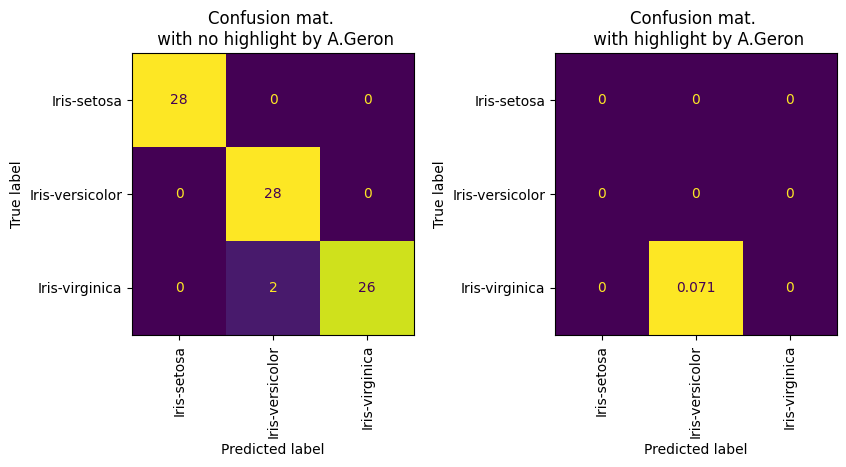

In [185]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(Y_true, Y_pred, labels, figsize=(15, 8)):
    conf_mat = confusion_matrix(y_true=Y_true, y_pred=Y_pred)
    print(f'Rows: groundtruth classes, columns: predicted classes!')

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax = ax.flatten()
    ax[0].set_title(f'Confusion mat. \n with no highlight by A.Geron')

    c = ConfusionMatrixDisplay(conf_mat, display_labels=labels)

    c.plot(ax=ax[0])
    ax[0].set_xticklabels(labels, rotation=90)


    row_sums = conf_mat.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mat / row_sums
    np.fill_diagonal(norm_conf_mx, 0)

    ConfusionMatrixDisplay(norm_conf_mx, display_labels=labels).plot(ax=ax[1])
    ax[1].set_title(f'Confusion mat. \n with highlight by A.Geron')
    ax[1].set_xticklabels(labels, rotation=90)


    fig.delaxes(fig.axes[3])
    fig.delaxes(fig.axes[2])


plot_confusion_matrix(
    Y_true=Y_trainval_processed,
    Y_pred=preds,
    labels=target_processor.classes_,
    figsize=(10, 5)
)

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(
    y_true=Y_trainval_processed,
    y_pred=preds
)

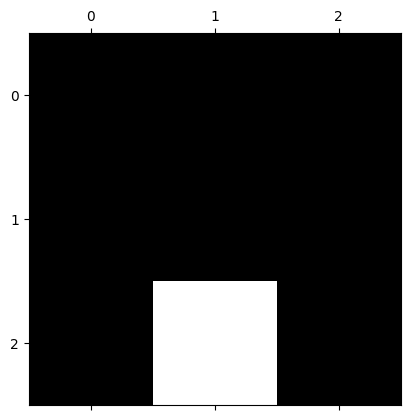

In [144]:
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mat / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

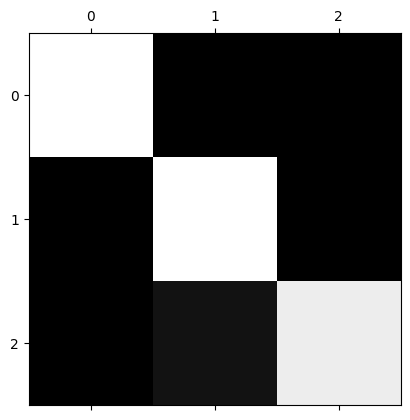

In [143]:
plt.matshow(conf_mat, cmap=plt.cm.gray)

In [124]:
def output_mistakes(Y_predicted, Y_processed, label_encoder):
    idxs = np.where(Y_predicted != Y_processed)[0]
    print(idxs, idxs.shape)
    for idx in idxs:
        # print(idx, predictions[idx])
        print(f'''
        Predicted: {label_encoder.inverse_transform(Y_predicted[[idx]])},
        Actual: {label_encoder.inverse_transform(Y_processed[[idx]])}
        ''')

output_mistakes(
    svc_random_search_res.best_estimator_.predict(
        np.vstack([X_train_processed, X_val_processed]),
    ),
    np.concatenate([Y_train_processed, Y_val_processed]),
    target_processor
)

[ 6 27 67] (3,)

        Predicted: ['Iris-versicolor'],
        Actual: ['Iris-virginica']
        

        Predicted: ['Iris-virginica'],
        Actual: ['Iris-versicolor']
        

        Predicted: ['Iris-virginica'],
        Actual: ['Iris-versicolor']
        


In [108]:
svc_random_search_res.best_estimator_.predict(
    [X_val_processed[0, :]]
), Y_val_processed[0]

(array([2]), 1)

## Gradient boosting

### Define the model

In [ ]:
%%capture
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

estimator = XGBClassifier()
estimator.fit(X_train_processed, Y_train_processed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
accuracy_score(
    estimator.predict(X_val_processed),
    Y_val_processed
)

0.8823529411764706

### Gridsearvh CV

In [ ]:
estimator = GridSearchCV(
    XGBClassifier(),
    {
        'n_estimators': [100, 200, 300],
        'random_state': [42]
    },
    cv=4,
    verbose=5,
    scoring='accuracy'
)

In [ ]:
res = estimator.fit(
    np.vstack([X_train_processed, X_val_processed]),
    np.concatenate([Y_train_processed, Y_val_processed])
)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END .n_estimators=100, random_state=42;, score=0.952 total time=   0.1s
[CV 2/4] END .n_estimators=100, random_state=42;, score=0.952 total time=   0.1s
[CV 3/4] END .n_estimators=100, random_state=42;, score=1.000 total time=   0.1s
[CV 4/4] END .n_estimators=100, random_state=42;, score=0.905 total time=   0.1s
[CV 1/4] END .n_estimators=200, random_state=42;, score=0.952 total time=   0.2s
[CV 2/4] END .n_estimators=200, random_state=42;, score=0.952 total time=   0.1s
[CV 3/4] END .n_estimators=200, random_state=42;, score=1.000 total time=   0.1s
[CV 4/4] END .n_estimators=200, random_state=42;, score=0.905 total time=   0.1s
[CV 1/4] END .n_estimators=300, random_state=42;, score=0.952 total time=   0.3s
[CV 2/4] END .n_estimators=300, random_state=42;, score=0.952 total time=   0.5s
[CV 3/4] END .n_estimators=300, random_state=42;, score=1.000 total time=   0.5s
[CV 4/4] END .n_estimators=300, random_state=42;,

In [ ]:
res.best_score_

0.9523809523809523

## CatBoost

### Define the model

In [ ]:
%%capture
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

estimator = CatBoostClassifier()
estimator.fit(X_train_processed, Y_train_processed)

Learning rate set to 0.068937
0:	learn: 1.0357319	total: 49.8ms	remaining: 49.7s
1:	learn: 0.9970008	total: 52.7ms	remaining: 26.3s
2:	learn: 0.9515786	total: 55.4ms	remaining: 18.4s
3:	learn: 0.9026687	total: 58.1ms	remaining: 14.5s
4:	learn: 0.8644363	total: 60.7ms	remaining: 12.1s
5:	learn: 0.8239919	total: 63.3ms	remaining: 10.5s
6:	learn: 0.7877247	total: 65.9ms	remaining: 9.34s
7:	learn: 0.7477912	total: 68.6ms	remaining: 8.5s
8:	learn: 0.7145462	total: 71.2ms	remaining: 7.84s
9:	learn: 0.6866400	total: 73.9ms	remaining: 7.32s
10:	learn: 0.6610939	total: 76.8ms	remaining: 6.91s
11:	learn: 0.6409979	total: 78.6ms	remaining: 6.47s
12:	learn: 0.6176282	total: 81.5ms	remaining: 6.19s
13:	learn: 0.5975172	total: 84.3ms	remaining: 5.93s
14:	learn: 0.5749446	total: 86.9ms	remaining: 5.7s
15:	learn: 0.5584845	total: 89.5ms	remaining: 5.51s
16:	learn: 0.5373124	total: 91.9ms	remaining: 5.31s
17:	learn: 0.5177410	total: 94.6ms	remaining: 5.16s
18:	learn: 0.4986203	total: 97.2ms	remaining: 

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(
    estimator.predict(X_val_processed),
    Y_val_processed
)

0.8823529411764706